# Lab2: Potential Functions

### Mazen Elgabalawy-u1999109
### Solomon Chibuzo Nwafor-u1999124

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import copy

Load Grid Map

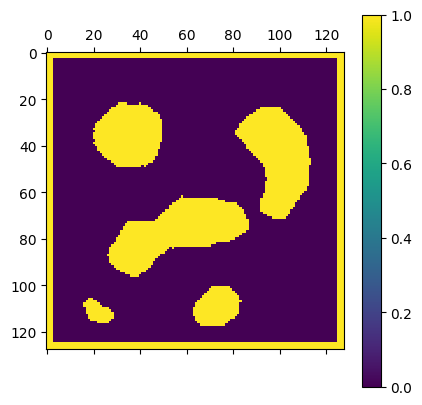

In [2]:
# Load grid map
image = Image.open('map0.png').convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
# binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
# Show grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()

Define Start and Goal positions

In [3]:
start = (10,10)
goal = (110, 40)

# Part 1

Define types of connectivity

In [4]:
connectivity_4 = [(0,-1),(-1,0),(1,0),(0,1)]
connectivity_8 = [(-1,-1),(0,-1),(1,-1),(-1,0),(1,0),(-1,1),(0,1),(1,1)]

### Excercise 1

Calculate attractive potential $U_{att}$ between the goal and every point in the gridmap according to the following relation

$$
    U_{att}(q) = \frac{1}{2} \zeta d^2(q, q_{goal})
$$

Where:
- $q$: robot configuration.
- $q_{goal}$: goal configuration.
- $d(q, q_{goal})$: Euclidean distance between robot and goal.
- $\zeta$: positive scaling factor to controls the strength of the pull.

In [5]:
def attraction_potential(grid_map,goal,zeta):
    attraction_map = np.zeros(np.shape(grid_map))

    rows = grid_map.shape[0]
    cols = grid_map.shape[1]
    for i in range(rows):
        for j in range(cols):
            attraction_map[i,j] = 0.5*zeta*((i-goal[0])**2 + (j-goal[1])**2)
    return attraction_map #return attraction map

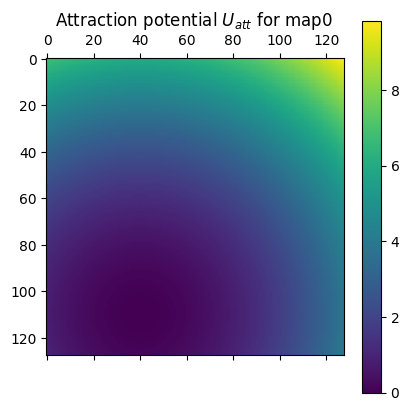

In [6]:
u_attraction = attraction_potential(grid_map,goal,zeta=0.001)
plt.matshow(u_attraction)
plt.title("Attraction potential $U_{att}$ for map0 ")
plt.colorbar()
plt.show()

### Exercise 2

Calculate distance map using *brushfire* algorithm

In [7]:
def brushfire(grid_map,connectivity):

    distance_map = copy.deepcopy(grid_map) # copy gridmap to avoid overwriting
    indices = np.where(grid_map==1) # get incicies of points that are obstacles (have a value of 1)
    queue = list(zip(indices[0], indices[1])) # create a queue with obstacle points

    while len(queue)!=0:
        current_x,current_y = queue[0] #get first point in queue
        queue.pop(0) # remove point from the queue

        for i, j in connectivity:
            new_x, new_y = current_x + i , current_y + j # get neighbour of current point
            if new_x in range(np.shape(grid_map)[0]) and new_y in range(np.shape(grid_map)[1]) and distance_map[new_x,new_y]== 0: # check if neighbour is inside bounds of map and has not been checked before
                distance_map[(new_x,new_y)] = distance_map[(current_x,current_y)] + 1
                queue.append((new_x,new_y)) # add point to queue
    return distance_map #return distance map

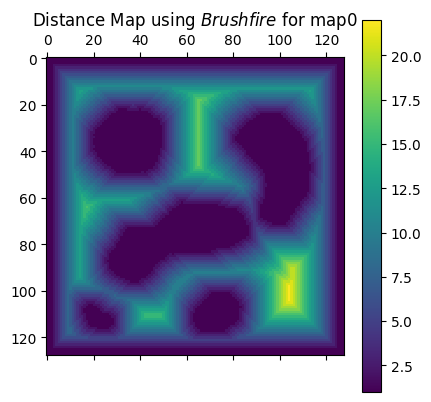

In [8]:
distance_map = brushfire(grid_map,connectivity_8)
plt.matshow(distance_map)
plt.title("Distance Map using $Brushfire$ for map0")
plt.colorbar()
plt.show()


## Exercise 3

In [9]:
def repulsive_potential(grid_map,Q=10,eta=5,connectivity=8):
    
    # eta is strength of repulsive force
    repulsion_map = np.zeros(np.shape(grid_map)) 
    distance_map = brushfire(grid_map,connectivity) # get distance map

    rows = grid_map.shape[0]
    cols = grid_map.shape[1]
    for i in range(rows):
        for j in range(cols):
            if distance_map[i,j] <= Q: # check if point is inside radius of infulence of obstacle
                repulsion_map[i,j] = 0.5*eta*(1/distance_map[i,j] - 1/Q)**2
    
    return repulsion_map , distance_map #return repulsion map and distance map

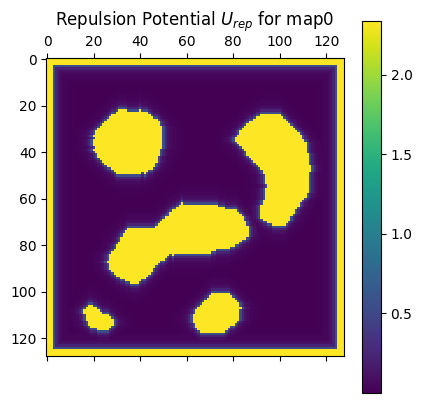

In [10]:
u_repulsion , distance_map = repulsive_potential(grid_map,Q=30,connectivity=connectivity_4)
plt.matshow(u_repulsion)
plt.title("Repulsion Potential $U_{rep}$ for map0")
plt.colorbar()
plt.show()

### Exercise 4

In [11]:
def total_potential(U_att,U_rep):
    return U_att + U_rep

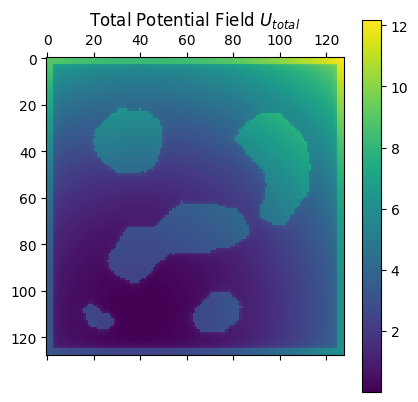

In [12]:
u_total = total_potential(u_attraction,u_repulsion)
plt.matshow(u_total)
plt.title("Total Potential Field $U_{total}$")
plt.colorbar()
plt.show()

# Part 2

### Exercise 5

Implement Gradient Descent for path palnning

In [13]:
def gradient_descent(potential_map, q_start,connectivity):
    path = [q_start] #add starting point to paths
    q = q_start    
    max_iter = 500 #maximum number of iterations to ensure not getting into an infinite loop
    i = 0
    threshold = 10e-5 #Threshold to stop the algorithm
    gradient = float('inf') #initialize first gradient to infinity

    while abs(gradient)>threshold:
        gradient = float('inf')
        current_x , current_y = q
        if i<=max_iter:
            for j,k in connectivity:
                new_x,new_y = current_x + j , current_y + k #get neighbours according to connectivity
                if new_x in range(np.shape(potential_map)[0]) and new_y in range(np.shape(potential_map)[1]): # check if neighbour is inside the gridmap
                    new_gradient = potential_map[(new_x,new_y)] - potential_map[(current_x,current_y)] # calculate gradient at neighbour point
                    if new_gradient<gradient and new_gradient<=0: # check if new_gradient is less than the current gradient
                        gradient = new_gradient
                        q = (new_x,new_y) # save the current neighbour
            path.append(q) # add neighbou with lowest potential to path
            i +=1
        else:
            return path
    
    return path

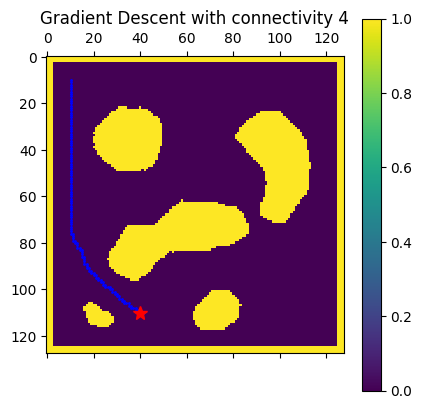

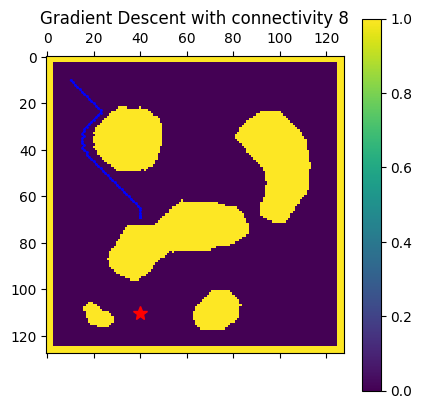

In [14]:
path_4 = gradient_descent(u_total,start,connectivity_4)
y,x = zip(*path_4)
plt.matshow(grid_map)
plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
plt.title("Gradient Descent with connectivity 4")
plt.colorbar()
plt.show()

path_8 = gradient_descent(u_total,start,connectivity_8)
y,x = zip(*path_8)
plt.matshow(grid_map)
plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
plt.title("Gradient Descent with connectivity 8")
plt.colorbar()
plt.show()


It can be seen that that gradient descent gets stuck at a local minimum. So it is not garantied that gradient descent will always find a path from the start to goal.

# Part 3

### Exercise 6

In [15]:
def wave_front_planner(grid_map,q_goal,connectivity):

    wave_map = copy.deepcopy(grid_map) # copy gridmap to avoid overwriting
    wave_map[q_goal] = 2 # set goal point to 2
    queue = [q_goal] # create a queue with goal as first element

    while len(queue)!=0:
        current_x , current_y = queue[0] # get first point in queue
        queue.pop(0) # remove point from queue

        for i, j in connectivity:
            new_x, new_y = current_x + i , current_y + j # get neighbour
            if new_x in range(np.shape(grid_map)[0]) and new_y in range(np.shape(grid_map)[1]): #check if neighbour is inside bounds of the map
                if wave_map[(new_x,new_y)] == 0 or wave_map[(new_x,new_y)]>wave_map[(current_x,current_y)]+1: # check if point has not been check
                    wave_map[(new_x,new_y)] = wave_map[(current_x,current_y)] + 1 # change value of point in the wave_map
                    queue.append((new_x,new_y)) # append point to the queue
                
    return wave_map



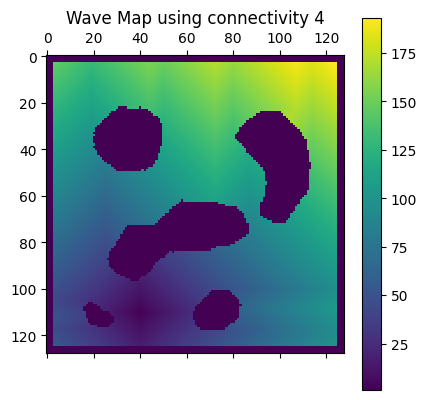

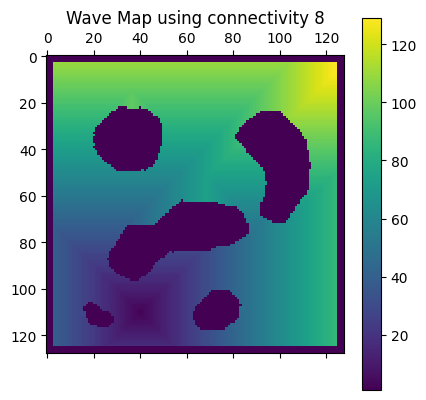

In [16]:
wave_map_4 = wave_front_planner(grid_map,goal,connectivity_4)
plt.matshow(wave_map_4)
plt.title("Wave Map using connectivity 4")
plt.colorbar()
plt.show()

wave_map_8 = wave_front_planner(grid_map,goal,connectivity_8)
plt.matshow(wave_map_8)
plt.title("Wave Map using connectivity 8")
plt.colorbar()
plt.show()

### Exercise 7

In [17]:
def find_path(wave_map,q_start,q_goal,connectivity):
    path = [q_start] # initiazlie path from start point
    q = q_start

    while q!=q_goal:
        min_neighbour = float('inf') # set minimum neighbour value as infinite
        current_x , current_y = q # get current point
        for i,j in connectivity:
            new_x,new_y = current_x + i , current_y + j # get neighbour
            if new_x in range(np.shape(wave_map)[0]) and new_y in range(np.shape(wave_map)[1]): # check if neighbour is inise the bounds of the map
                if wave_map[(new_x,new_y)]<=min_neighbour and wave_map[(new_x,new_y)]!=1: # check if neighbour value is less than its surroundings and check if it it not an obstacle
                    min_neighbour = wave_map[(new_x,new_y)] # set value of new_neighbour
                    q = (new_x,new_y) # set q as neighbour with minimum_value
        path.append(q)

    return path

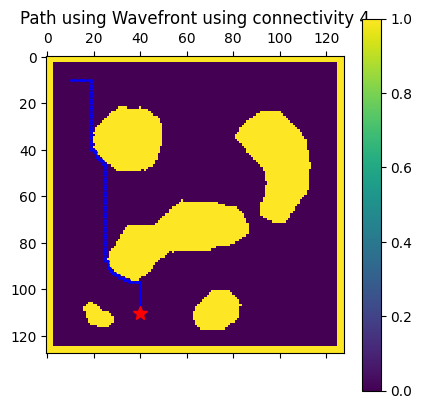

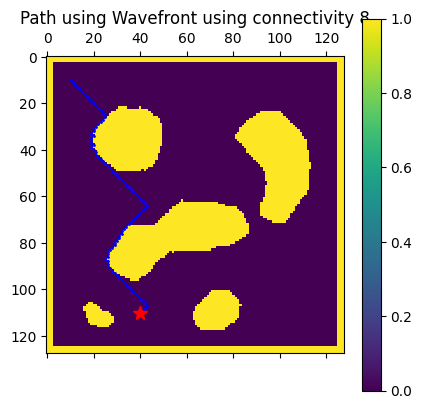

In [18]:
path_wave_4 = find_path(wave_map_4,start,goal,connectivity_4)
y,x = zip(*path_wave_4)
plt.matshow(grid_map)
plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
plt.title("Path using Wavefront using connectivity 4")
plt.colorbar()
plt.show()

path_wave_8 = find_path(wave_map_8,start,goal,connectivity_8)
y,x = zip(*path_wave_8)
plt.matshow(grid_map)
plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
plt.title("Path using Wavefront using connectivity 8")
plt.colorbar()
plt.show()

It can be seen that the wave-front path planner is able to reach the goal without getting stuck in a local minimum

# Testing

Create function that tests all maps with their respective start and goal points with both Gradient Descent and Wave-front Planner

The following maps with the proposed *start* and *goal* loacations are provided:

| grid map name | start     | goal                 |
|---------------|-----------|----------------------|
| map0.png      | (10, 10)  | (110, 40) & (90, 70) |

You may try also

| grid map name | start     | goal      |
|---------------|-----------|-----------|
| map1.png      | (60, 60)  | (90, 60)  | 
| map2.png      | (8, 31)   | (139, 38) |
| map3.png      | (50, 90)  | (375, 375)|

In [19]:
# Define dictionary with all maps and corresponding start and goal
maps = {'map0.png':[(10,10),(90,70)],
        'map1.png':[(60,60),(90,60)],
        'map2.png':[(8,31),(139,38)],
        'map3.png':[(50,90),(375,375)]}

zeta = 0.001
Q = 30

In [20]:
def test_maps(maps):
    for key in maps:
        # Define start and goal points
        start = maps[key][0]
        goal = maps[key][1]
        
        # Load grid map
        image = Image.open(key).convert('L')
        grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
        # binarize the image
        grid_map[grid_map > 0.5] = 1
        grid_map[grid_map <= 0.5] = 0
        # Invert colors to make 0 -> free and 1 -> occupied
        grid_map = (grid_map * -1) + 1
        # Show grid map
        plt.matshow(grid_map)
        plt.title(key.replace(".png",""))
        plt.colorbar()
        plt.show()
        #Attraction potential
        u_attraction = attraction_potential(grid_map,goal,zeta)
        plt.matshow(u_attraction)
        plt.title("Attraction potential $U_{att}$ for " + key.replace(".png",""))
        plt.colorbar()
        plt.show()
        #Repulsive potential
        u_repulsion , distance_map = repulsive_potential(grid_map,Q,connectivity_8)
        plt.matshow(distance_map)
        plt.title("Distance map for " + key.replace(".png",""))
        plt.colorbar()
        plt.show()
        plt.matshow(u_repulsion)
        plt.title("Repulsion potential $U_{rep}$ for " + key.replace(".png",""))
        plt.colorbar()
        plt.show()
        #Total Potential
        u_total = total_potential(u_attraction,u_repulsion)
        plt.matshow(u_total)
        plt.title("Total potential U for " + key.replace(".png",""))
        plt.colorbar()
        plt.show()

        # Gradient Descent
        # Connectivity 4
        path_4 = gradient_descent(u_total,start,connectivity_4)
        y,x = zip(*path_4)
        plt.matshow(grid_map)
        plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
        plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
        plt.title("Gradient Descent with connectivity 4")
        plt.colorbar()
        plt.show()
        # Connectivity 8
        path_8 = gradient_descent(u_total,start,connectivity_8)
        y,x = zip(*path_8)
        plt.matshow(grid_map)
        plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
        plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
        plt.title("Gradient Descent with connectivity 8")
        plt.colorbar()
        plt.show()
        # Wavefront Planner
        # Connectivity 4
        wave_map_4 = wave_front_planner(grid_map,goal,connectivity_4)
        plt.matshow(wave_map_4)
        plt.title("Wave Map using connectivity 4")
        plt.colorbar()
        plt.show()

        path_wave_4 = find_path(wave_map_4,start,goal,connectivity_4)
        y,x = zip(*path_wave_4)
        plt.matshow(grid_map)
        plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
        plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
        plt.title("Path using Wavefront using connectivity 4")
        plt.colorbar()
        plt.show()

        #Connectivity 8
        wave_map_8 = wave_front_planner(grid_map,goal,connectivity_8)
        plt.matshow(wave_map_8)
        plt.title("Wave Map using connectivity 8")
        plt.colorbar()
        plt.show()

        path_wave_8 = find_path(wave_map_8,start,goal,connectivity_8)
        y,x = zip(*path_wave_8)
        plt.matshow(grid_map)
        plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
        plt.plot(goal[1],goal[0],marker="*",markersize=10,color='red')
        plt.title("Path using Wavefront using connectivity 8")
        plt.colorbar()
        plt.show()

        
        

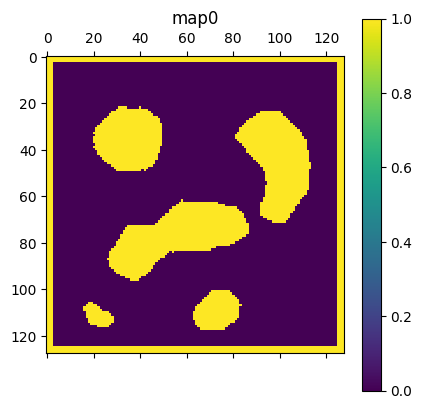

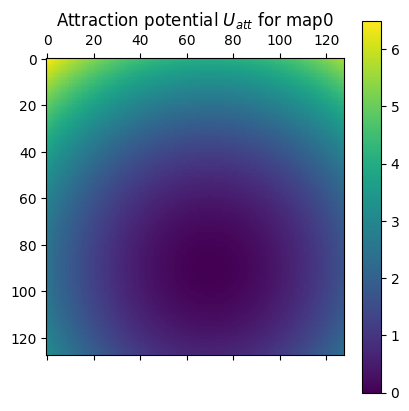

TypeError: 'int' object is not iterable

In [21]:
test_maps(maps)